In [56]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('lemmatize')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import os as os

from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout,Bidirectional,LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Error loading lemmatize: Package 'lemmatize' not found in
[nltk_data]     index


## **PARTIE 2 : DEEP LEARNING**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Premier modèle RNN

In [3]:
#On charge le dataset d'entrainement
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/X_train.csv", sep=',',index_col=0)
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Y_train.csv", sep=',',index_col=0)

# On charge les intitulés de catégorie
categories = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/categories.csv",sep=';',index_col=0)

In [4]:
# Nettoya du dataset

X = pd.concat([X_train, y_train], axis=1)
X["categorie"] = X.prdtypecode.map(categories.prdlabelcode)
X["image"] = "image_" + X.imageid.astype(str) + "_product_" + X.productid.astype(str) + ".jpg"
X["texte"] = X.designation + " " + X.description.fillna('').astype(str)
X.drop(["productid", "imageid", "designation", "description"], axis=1, inplace=True)

X.drop_duplicates(subset="texte", inplace=True)

# On enleve les tags htmls dans le texte (titre + description) des annonces
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

X["texte"] = X.texte.apply(strip_tags)

In [5]:
#Separation du jeu de données en jeu d'entrainement et jeu de test + separation d'avec la variable cible

X_train, X_test, y_train, y_test = train_test_split(X.texte, X.prdtypecode, test_size = 0.2)


In [6]:
# On définit un Tokeniser (celui par défaut de Keras Tensorflow)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)

# Mise à jour du dictionnaire du tokenizer
tokenizer.fit_on_texts(X_train)

In [7]:
# Définition des dictionnaires
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = tokenizer.num_words

In [8]:
#Affichage de la taille du vocabulaire : cette information sera utile car elle pourra etre utilisée lors de la modélisation Deep
print(vocab_size)

10000


In [9]:
#A cette étape, nous devons transformer les descriptions des produits en une séquence d'entiers.
#chaque mot de la description sera encodé sous forme d'entiers afin d'etre utilisé par la suite dans le 
#modèle RNN

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [10]:
#On evalue d'abord le nombre moyen de mot par description. Ceci afin de définir un nombre de maxlen
#coherent avec notre jeu de données

mot_description = [len(x) for x in X_train]

print(np.mean(mot_description))

79.43527791500128


In [11]:
maxlen = math.ceil(np.mean(mot_description))
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

In [34]:

embedding_dim = 300


model_RNN = Sequential()
model_RNN.add(Embedding(10000, embedding_dim)) #première couche pour transformer chaque index de mot en vecteur

model_RNN.add(RNN(GRUCell(128), return_sequences=True))
model_RNN.add(Dropout(0.3))

model_RNN.add(GlobalAveragePooling1D()) #Application du bag of word
model_RNN.add(Dense(256, activation='relu'))
model_RNN.add(Dropout(0.3))
model_RNN.add(Dense(len(categories), activation='softmax'))

model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 rnn_1 (RNN)                 (None, None, 128)         165120    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [35]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [36]:
y_test_label = label_encoder.transform(y_test)
train_size = len(X_train)
valid_size = len(X_test)


In [37]:
model_RNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_deep_text'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True)



In [39]:
history = model_RNN.fit(X_train, y_train_label,
    batch_size = 64,
    epochs=10,
    validation_data = [X_test, y_test_label],
    callbacks=[model_checkpoint_callback,earlystop])

Epoch 1/10
1044/1044 [==============================] - 299s 285ms/step - loss: 1.3086 - accuracy: 0.6108 - val_loss: 0.8254 - val_accuracy: 0.7596
Epoch 2/10
1044/1044 [==============================] - 307s 294ms/step - loss: 0.6713 - accuracy: 0.8037 - val_loss: 0.7082 - val_accuracy: 0.7940
Epoch 3/10
1044/1044 [==============================] - 295s 283ms/step - loss: 0.5091 - accuracy: 0.8459 - val_loss: 0.7044 - val_accuracy: 0.7981
Epoch 4/10
1044/1044 [==============================] - 295s 282ms/step - loss: 0.4051 - accuracy: 0.8755 - val_loss: 0.7458 - val_accuracy: 0.7964
Epoch 5/10
1044/1044 [==============================] - 292s 280ms/step - loss: 0.3265 - accuracy: 0.8969 - val_loss: 0.7871 - val_accuracy: 0.7976
Epoch 6/10
1044/1044 [==============================] - 296s 283ms/step - loss: 0.2670 - accuracy: 0.9153 - val_loss: 0.8933 - val_accuracy: 0.7959
Epoch 7/10
1044/1044 [==============================] - 295s 282ms/step - loss: 0.2198 - accuracy: 0.9294 - val_

In [40]:
model_RNN.evaluate(X_test, y_test_label, batch_size=128)

131/131 [==============================] - 14s 106ms/step - loss: 0.7044 - accuracy: 0.7981


[0.7043910026550293, 0.7980959415435791]

In [41]:
history = history.history

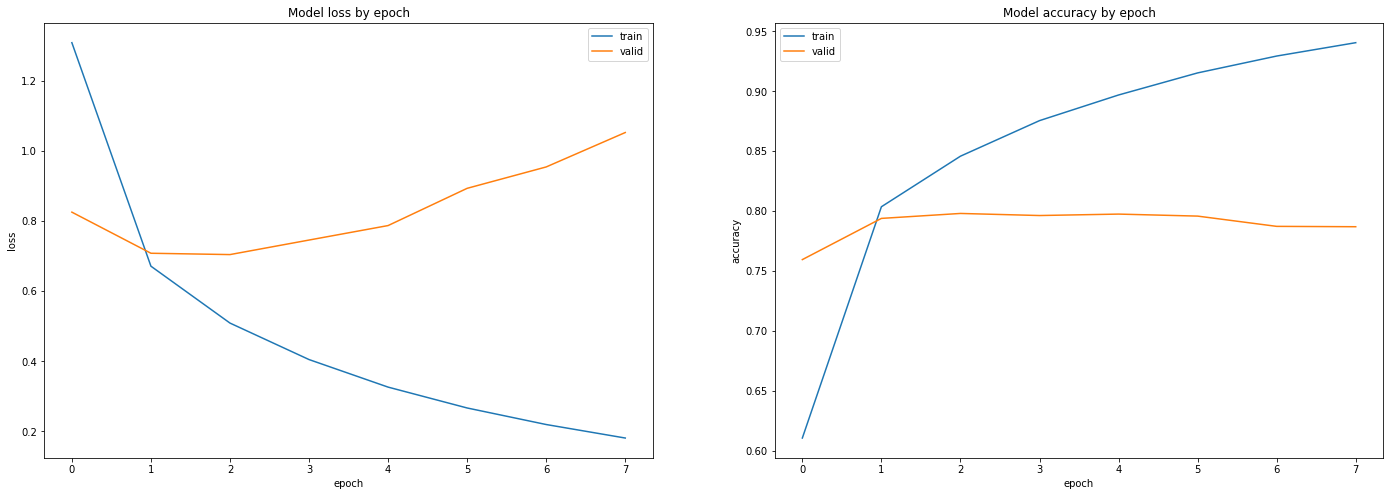

In [42]:
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [43]:
y_pred = model_RNN.predict(X_test)

y_test_pred_class = y_pred.argmax(axis = 1)

Matrice de confusion

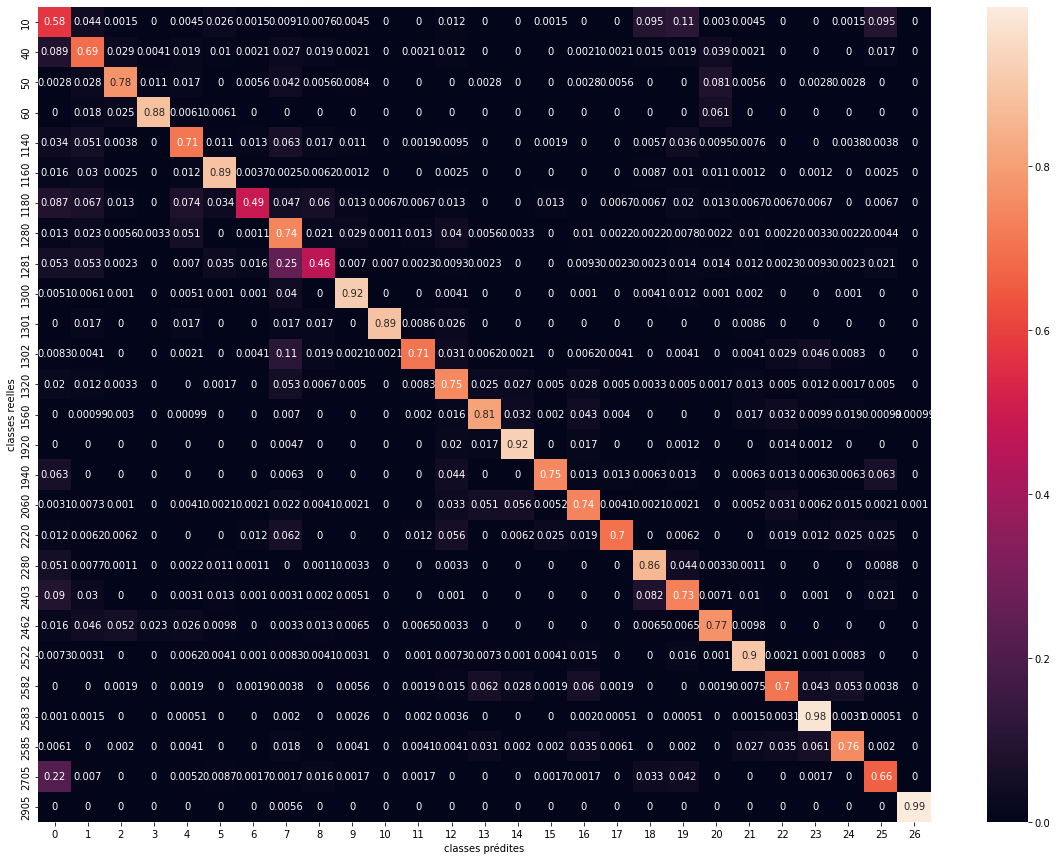

In [44]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, y_test_pred_class, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

#A corriger, car il faut afficher les labels des classes pour faciliter l'analyse

In [33]:
#from sklearn.metrics import classification_report
#report = pd.DataFrame(classification_report(y_test, y_test_pred_class, output_dict=True))
#display(report.sort_values(by="f1-score", ascending=False))
#report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

,0,1,2,3,4,5,6,7,8,9,...,2462,2522,2582,2583,2585,2705,2905,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1-score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
support,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,307.0,964.0,532.0,1958.0,490.0,575.0,180.0,0.0,16701.0,16701.0


In [45]:
embedding_dim = 200


model_RNN2 = Sequential()
model_RNN2.add(Embedding(10000, embedding_dim)) #première couche pour transformer chaque index de mot en vecteur

model_RNN2.add(RNN(GRUCell(128), return_sequences=True))
model_RNN2.add(Dropout(0.2))

model_RNN2.add(GlobalAveragePooling1D()) #Application du bag of word
model_RNN2.add(Dense(256, activation='relu'))
model_RNN2.add(Dropout(0.2))
model_RNN2.add(Dense(len(categories), activation='softmax'))

model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 rnn_2 (RNN)                 (None, None, 128)         126720    
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [46]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [47]:
y_test_label = label_encoder.transform(y_test)
train_size = len(X_train)
valid_size = len(X_test)

In [48]:
model_RNN2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
checkpoint_filepath = 'drive/MyDrive/checkpoint_deep_text'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True)

In [50]:
history = model_RNN2.fit(X_train, y_train_label,
    batch_size = 64,
    epochs=10,
    validation_data = [X_test, y_test_label],
    callbacks=[model_checkpoint_callback,earlystop])

Epoch 1/10
1044/1044 [==============================] - 246s 234ms/step - loss: 1.3808 - accuracy: 0.5877 - val_loss: 0.8491 - val_accuracy: 0.7519
Epoch 2/10
1044/1044 [==============================] - 244s 234ms/step - loss: 0.6881 - accuracy: 0.7963 - val_loss: 0.7390 - val_accuracy: 0.7834
Epoch 3/10
1044/1044 [==============================] - 244s 234ms/step - loss: 0.5294 - accuracy: 0.8410 - val_loss: 0.7227 - val_accuracy: 0.7904
Epoch 4/10
1044/1044 [==============================] - 244s 234ms/step - loss: 0.4312 - accuracy: 0.8680 - val_loss: 0.7610 - val_accuracy: 0.7925
Epoch 5/10
1044/1044 [==============================] - 243s 232ms/step - loss: 0.3582 - accuracy: 0.8885 - val_loss: 0.8121 - val_accuracy: 0.7901
Epoch 6/10
1044/1044 [==============================] - 245s 235ms/step - loss: 0.2968 - accuracy: 0.9064 - val_loss: 0.8826 - val_accuracy: 0.7861
Epoch 7/10
1044/1044 [==============================] - 246s 236ms/step - loss: 0.2478 - accuracy: 0.9209 - val_

In [51]:
model_RNN2.evaluate(X_test, y_test_label, batch_size=128)

131/131 [==============================] - 12s 94ms/step - loss: 0.7227 - accuracy: 0.7904


[0.7227216958999634, 0.790371835231781]

In [52]:
history = history.history

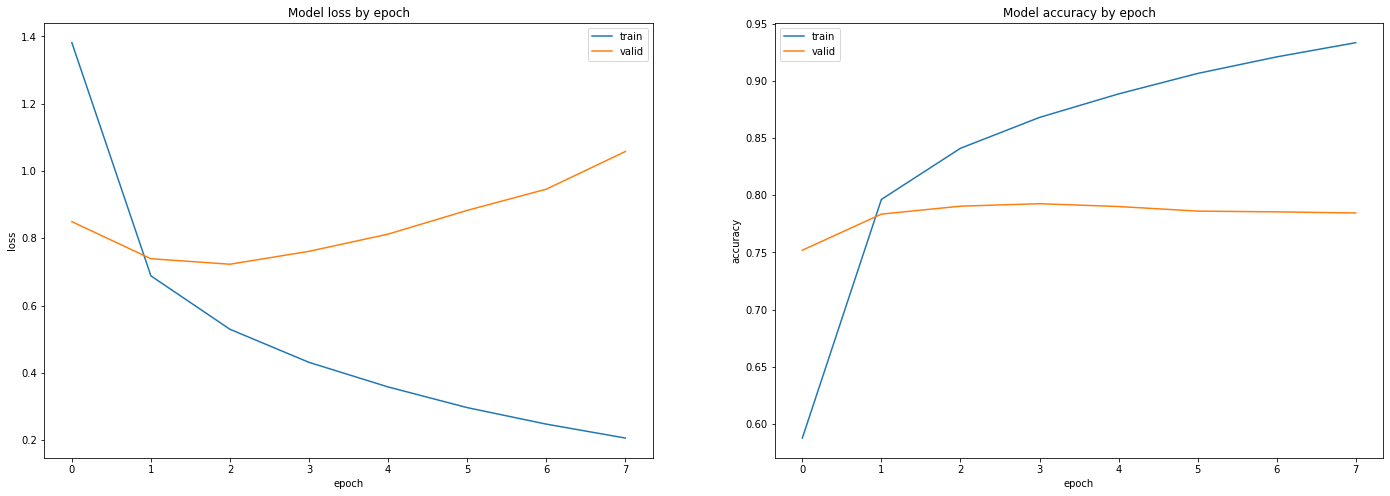

In [53]:
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#Modèle LSTM

In [57]:
embedding_dim = 200


model_LSTM = Sequential()
model_LSTM.add(Embedding(10000, embedding_dim))
model_LSTM.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model_LSTM.add(Dense(27, activation='softmax'))

model_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense_6 (Dense)             (None, 27)                3483      
                                                                 
Total params: 2,171,931
Trainable params: 2,171,931
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_LSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model_LSTM.fit(X_train, y_train_label,
    batch_size = 64,
    epochs=10,
    validation_data = [X_test, y_test_label],
    callbacks=[model_checkpoint_callback,earlystop])

Epoch 1/10
1044/1044 [==============================] - 429s 406ms/step - loss: 2.5993 - accuracy: 0.2228 - val_loss: 2.1130 - val_accuracy: 0.3469
Epoch 2/10
1044/1044 [==============================] - 423s 405ms/step - loss: 1.7130 - accuracy: 0.4699 - val_loss: 1.3828 - val_accuracy: 0.5736
Epoch 3/10
1044/1044 [==============================] - 423s 405ms/step - loss: 1.0321 - accuracy: 0.6856 - val_loss: 0.8950 - val_accuracy: 0.7383
Epoch 4/10
1044/1044 [==============================] - 423s 405ms/step - loss: 0.7008 - accuracy: 0.7916 - val_loss: 0.7704 - val_accuracy: 0.7734
Epoch 5/10
1044/1044 [==============================] - 423s 405ms/step - loss: 0.5577 - accuracy: 0.8332 - val_loss: 0.7381 - val_accuracy: 0.7854
Epoch 6/10
1044/1044 [==============================] - 420s 402ms/step - loss: 0.4608 - accuracy: 0.8622 - val_loss: 0.7466 - val_accuracy: 0.7890
Epoch 7/10
1044/1044 [==============================] - 423s 405ms/step - loss: 0.3905 - accuracy: 0.8818 - val_

In [60]:
model_LSTM.evaluate(X_test, y_test_label, batch_size=128)

131/131 [==============================] - 17s 126ms/step - loss: 0.7381 - accuracy: 0.7854


[0.7380853295326233, 0.7854020595550537]

In [61]:
history = history.history

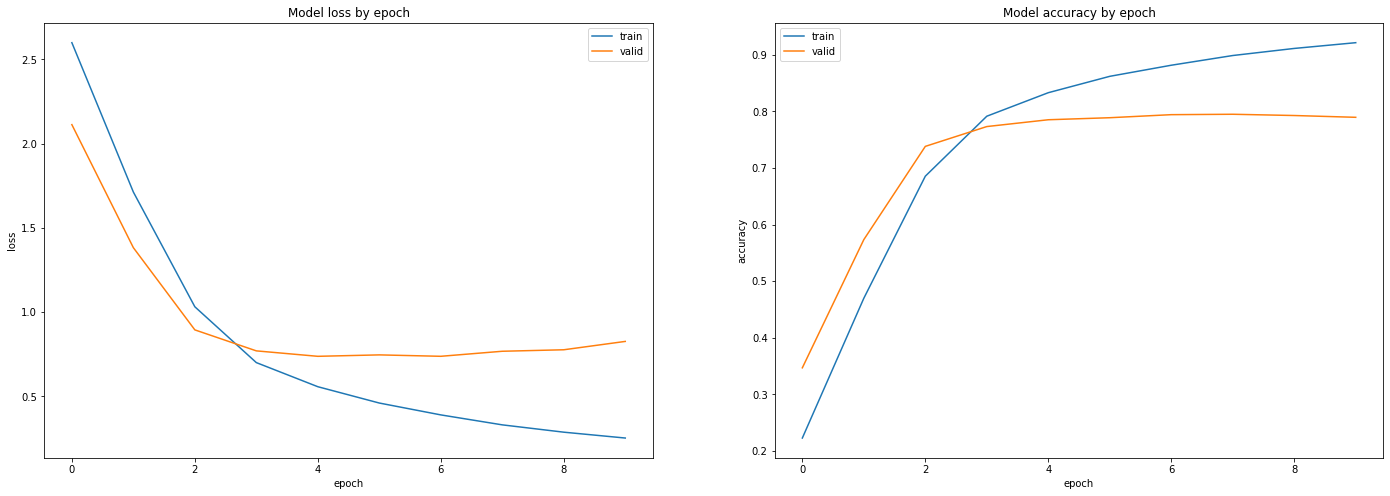

In [62]:
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()